# CRM using Simpy

CRM system simulation using simpy. 

Company CRM populated with accounts (customer companies) and opportunities coming from time to time from these accounts and which can be bidded, won or lost by Company.

Principles: Account "agents" wich will go through a set of events, namely:
- inbound_mktg_event: account finds the contant and follows a CTA to be added into Company MQL list
- outbount_mkt_event: account reached by Company outbound marketing actions and follows a CTA to be added into Company MQL
- inbound_sales_event: account is identified as a sales qualified leads and converted into prospect
- outbound_sales_event: account reached out by Company sales representative and accepts call to become a prospect
and other similar events representing how an account moves from stage to stage through the sales funnel and sales process

Each event is the result of:
- the current phase where the account is 
- an adjustable random variable, using some paramaters (example, conversion rate for CTA, ...)

In [406]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import simpy

from datetime import datetime, timedelta
from eccore.ipython import nb_setup
from pathlib import Path
from pprint import pprint
from uuid import uuid4
nb_setup()

from agents import MarketingDpt, SalesRep, Account
from agents import record_accounts_stats
from crm import CustomerRelationManagerSimulator
from enums import AccountStatus, AccountType, AccountStage, Country, Industry
from enums import LeadSource, MarketingMessages, SalesRepMessages, SalesRejectionMessages
from utils import account_info_generator, salesrep_name_generator

random.seed(1988)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode


## Manual environment

In [407]:
env = simpy.Environment()
# env.salesreps = [SalesRep(env, f"SalesRep-{i}") for i in range(5)]
[SalesRep(env, f"SalesRep-{i}") for i in range(5)]
# env.accounts = []
marketing = MarketingDpt(env)
Account.reset_counter()
for i in range(5):
    a = Account(env, f"Account-{i}", marketing)
gsr = itertools.cycle(env.salesreps)
for i in range(5,10):
    a = Account(env, f"Account-{i}", marketing)
    a.stage = AccountStage.SQL
    salesrep = next(gsr)
    a.assigned_salesrep = salesrep
    salesrep.assigned_accounts.append(a)
    # print(a.name, a.stage, a.assigned_salesrep.name)

record_stats = env.process(record_accounts_stats(env))

In [408]:
# env.run(until=env.peek()+1)
env.run(until=10)

[0.00] Marketing: Found 5 MQL accounts
[0.00] SalesRep-0: Sent user need review for Account-5 (acct-d2cdfee3-5921-47bf-a933-db8b46ac3d65)
[0.00] SalesRep-1: Sent user need review for Account-6 (acct-54f69e88-cd9b-4d58-8262-356b70a20f21)
[0.00] SalesRep-2: Sent user need review for Account-7 (acct-6c2d2367-fdcd-43ef-96ca-2c4da539cade)
[0.00] SalesRep-3: Sent user need review for Account-8 (acct-19889c54-8a9d-4547-bde5-bae8d05528f5)
[0.00] SalesRep-4: Sent user need review for Account-9 (acct-d2f86a7e-86c1-415a-9870-a8c04111706a)
[0.60] Marketing: Received message: acct-f10b2a35-2600-4d4a-9ba3-83a5ae137091|||email campaign
[0.60] Marketing: Converted Account-2 to SQL stage
[0.60] Marketing: Assigned Account-2 to SalesRep-0
[1.00] SalesRep-0: Sent user need review for Account-5 (acct-d2cdfee3-5921-47bf-a933-db8b46ac3d65)
[1.00] SalesRep-1: Sent user need review for Account-6 (acct-54f69e88-cd9b-4d58-8262-356b70a20f21)
[1.00] SalesRep-2: Sent user need review for Account-7 (acct-6c2d2367-f

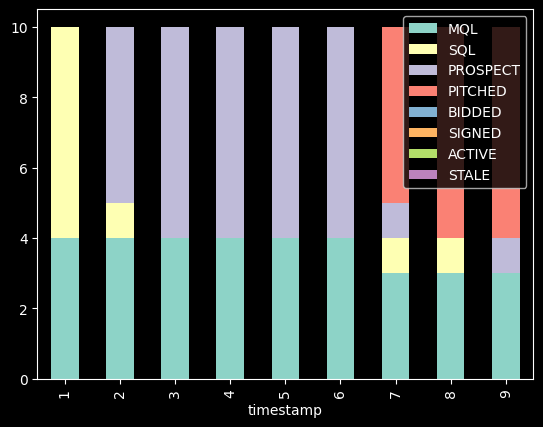

In [409]:
pd.DataFrame(data = env.account_stats).drop(columns=['LEAD', 'nb_accounts']).set_index('timestamp').plot(kind="bar", stacked=True);

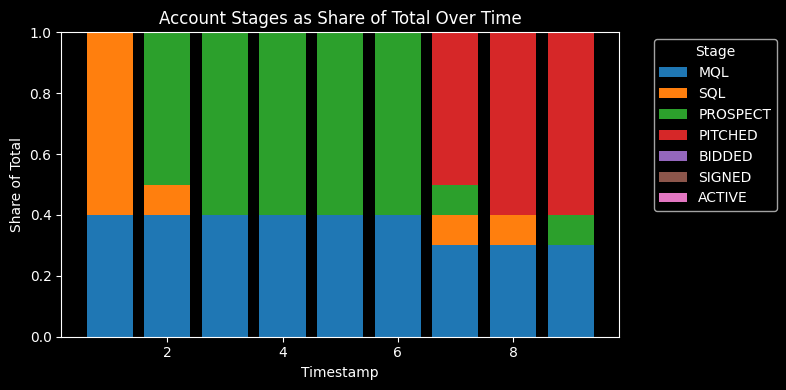

In [410]:
df = pd.DataFrame(data=env.account_stats).drop(columns=['LEAD','STALE', 'nb_accounts']).set_index('timestamp')
df_pct = df.div(df.sum(axis=1), axis=0)  # Normalize to share

# Prepare for stacking
bottom = np.zeros(len(df_pct))
x = df_pct.index
colors = sns.color_palette("tab10", n_colors=len(df_pct.columns))

plt.figure(figsize=(8,4))
for i, col in enumerate(df_pct.columns):
    plt.bar(x, df_pct[col], bottom=bottom, label=col, color=colors[i])
    bottom += df_pct[col].values

plt.xlabel("Timestamp")
plt.ylabel("Share of Total")
plt.title("Account Stages as Share of Total Over Time")
plt.legend(title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [411]:
pd.DataFrame(env.crm_transactions)


,timestamp,initiator,recipient,message,type
0,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-bde81af5-8c6c-4b75-b540-e2a2d3b28e47,NewMQL,Internal
1,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-eff2f8a9-9154-4f61-a725-4dca3a628153,NewMQL,Internal
2,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-f10b2a35-2600-4d4a-9ba3-83a5ae137091,NewMQL,Internal
3,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-0be652b3-c826-4d38-8ee9-35ba17a55cdb,NewMQL,Internal
4,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-158174d4-63bb-4f7c-8752-23052cdfe432,NewMQL,Internal
...,...,...,...,...,...
120,9.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-bde81af5-8c6c-4b75-b540-e2a2d3b28e47,email campaign,External
121,9.6,acct-0be652b3-c826-4d38-8ee9-35ba17a55cdb,mktg-e2333305-db9e-480a-a050-5a4161254642,email campaign,External
122,9.6,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-0be652b3-c826-4d38-8ee9-35ba17a55cdb,MQL2SQL,Internal
123,9.6,acct-bde81af5-8c6c-4b75-b540-e2a2d3b28e47,mktg-e2333305-db9e-480a-a050-5a4161254642,email campaign,External


In [412]:
pd.DataFrame(env.crm_transactions)

,timestamp,initiator,recipient,message,type
0,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-bde81af5-8c6c-4b75-b540-e2a2d3b28e47,NewMQL,Internal
1,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-eff2f8a9-9154-4f61-a725-4dca3a628153,NewMQL,Internal
2,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-f10b2a35-2600-4d4a-9ba3-83a5ae137091,NewMQL,Internal
3,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-0be652b3-c826-4d38-8ee9-35ba17a55cdb,NewMQL,Internal
4,0.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-158174d4-63bb-4f7c-8752-23052cdfe432,NewMQL,Internal
...,...,...,...,...,...
120,9.0,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-bde81af5-8c6c-4b75-b540-e2a2d3b28e47,email campaign,External
121,9.6,acct-0be652b3-c826-4d38-8ee9-35ba17a55cdb,mktg-e2333305-db9e-480a-a050-5a4161254642,email campaign,External
122,9.6,mktg-e2333305-db9e-480a-a050-5a4161254642,acct-0be652b3-c826-4d38-8ee9-35ba17a55cdb,MQL2SQL,Internal
123,9.6,acct-bde81af5-8c6c-4b75-b540-e2a2d3b28e47,mktg-e2333305-db9e-480a-a050-5a4161254642,email campaign,External


## CRM Environment

#### Reference Conversion Rates

##### MQL
- website
    - nb mthly website visitor=2900 monthly
    - website cta rate=0.03
- email
    - online campaigns targets=1000 monthly
    - online campaigns clickthru=0.1
- industry event
    - nb industry events=1 quarterly
    - rawleads industry events=80 * nb industry events
- direct calls
    - rawleads salesreps=30 monthly (?)
- conversion 
    - rawlead2mql website=0.41
    - rawlead2mql online campaign=0.38
    - rawlead2mql industry event=0.3
    - salesrep leads2mql=0.02

##### SQL and later stages
- conversion
    - mql2sql=0.15
    - sql2prospect=0.7
    - prospect2prez=0.7
    - prez2bid=0.6
    - bid2close=0.3
    - customer satisfaction rate=0.98

- delays
    - mql2sql= 1 to 2 weeks
    - sql2prospect= 1 to 2 weeks
    - prospect2prez= 1 to 4 weeks
    - prez2bid= 2 to 12 weeks
    - bid2close= 2 to 12 weeks
    - customer project duration = 12 to 24 weeks


- decay rate=0.15

#### Code

Using the class `CustomerRelationManagerSimulator`

In [413]:
crm = CustomerRelationManagerSimulator(nb_salesreps=10, nb_mql_accounts=100, nb_sql_accounts=100)
len(crm.env.sales_reps),len(crm.env.accounts)

Created 100 MQL accounts
Created 100 SQL accounts
Created 15 PROSPECT accounts
Created 12 PITCHED accounts
Created 9 BIDDED accounts
Created 5 SIGNED accounts
Total accounts created: 241


(10, 241)

In [414]:
# crm.iterate()
crm.run(until=52*5)

[0.00] Marketing: Found 100 MQL accounts
[3.00] Marketing: Found 102 MQL accounts
[6.00] Marketing: Found 102 MQL accounts
[6.60] Marketing: Received message: acct-26997a9c-83dc-45da-a508-63d3adc5bbaa|||email campaign
[6.60] Marketing: Converted XiangtanFlex Industries to SQL stage
[6.60] Marketing: Assigned XiangtanFlex Industries to SalesRep 1
[7.00] SalesRep 1: Sent user need review for XiangtanFlex Industries (acct-26997a9c-83dc-45da-a508-63d3adc5bbaa)
[8.00] SalesRep 1: Sent user need review for XiangtanFlex Industries (acct-26997a9c-83dc-45da-a508-63d3adc5bbaa)
[8.00] SalesRep 1: Converting XiangtanFlex Industries from SQL to PROSPECT stage
[9.00] Marketing: Found 101 MQL accounts
[9.00] SalesRep 1: Sent presentation request for XiangtanFlex Industries (acct-26997a9c-83dc-45da-a508-63d3adc5bbaa)
[10.00] SalesRep 1: Sent presentation request for XiangtanFlex Industries (acct-26997a9c-83dc-45da-a508-63d3adc5bbaa)
[11.00] SalesRep 1: Sent presentation request for XiangtanFlex Indust

In [416]:
df = crm.get_account_stats()
coi = ['MQL', 'SQL', 'PROSPECT', 'PITCHED', 'BIDDED', 'SIGNED', 'ACTIVE', 'STALE']
coi = ['PROSPECT', 'PITCHED', 'BIDDED', 'SIGNED', 'ACTIVE', 'STALE']
df.loc[:, coi].div(df.loc[:,coi].sum(axis=1), axis=0).mean(axis=0)
df.loc[:, coi].mean(axis=0)

df.tail()


,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
timestamp,,,,,,,,,,
2030-08-31,296,0,116,103,23,20,22,12,0,0
2030-09-30,298,0,117,104,23,21,21,12,0,0
2030-10-31,298,0,117,104,20,24,21,12,0,0
2030-11-30,298,0,117,104,19,25,21,12,0,0
2030-12-31,298,0,117,104,19,24,22,12,0,0


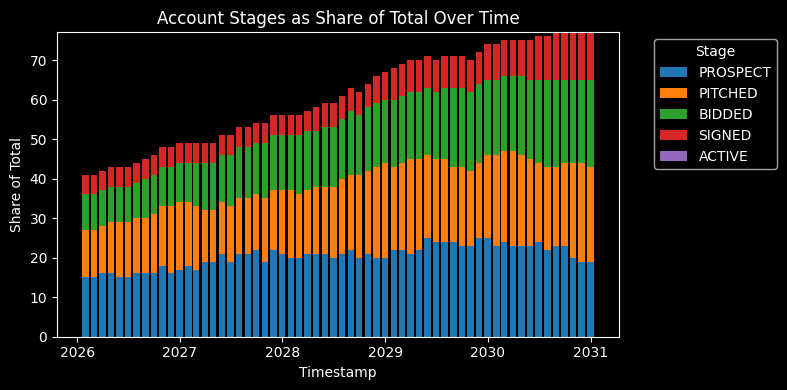

In [417]:
crm.plot_account_stats(as_share=False, hide_mql=True, hide_mql_sql=True)

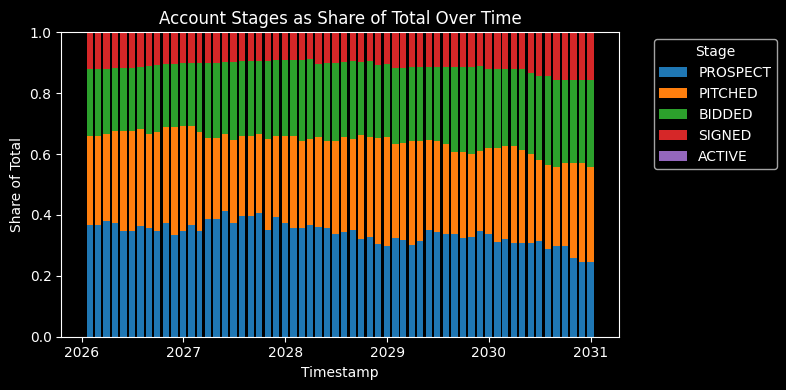

In [418]:
crm.plot_account_stats(as_share=True, hide_mql=True, hide_mql_sql=True)

In [ ]:
df = crm.get_crm_transactions()
df.loc[df.message.str.contains('lost'), :]

,timestamp,initiator,recipient,message,type
252,6.6,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,mktg-eb5af7ab-cb2d-4b08-93e0-d8ce1086bb15,email campaign,External
256,8.0,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,srep-574e41e2-8353-4872-a350-bbe4753e8b78,user need review,External
261,9.0,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,srep-574e41e2-8353-4872-a350-bbe4753e8b78,user need review,External
270,12.6,acct-3d4ac256-f335-4f5b-a382-d63c681cf176,mktg-eb5af7ab-cb2d-4b08-93e0-d8ce1086bb15,email campaign,External
274,13.0,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,srep-574e41e2-8353-4872-a350-bbe4753e8b78,presentation request,External
...,...,...,...,...,...
7497,259.0,acct-f61e839f-d311-4fd5-867d-d83a931774dc,srep-55034c84-2eb6-412c-9fb0-1b64bbfdfd2e,presentation request,External
7498,259.0,acct-1f90c9b5-cfa0-486f-9138-7c7965b7ffc1,srep-05499666-f240-479b-8516-95a6f372cf36,account did not invite us to bid,External
7499,259.0,acct-83bed288-8837-4a44-a5a9-3577ee054a89,srep-ef3fa8f0-974b-46c2-80ca-361d65220fa6,bid submission,External
7500,259.0,acct-57c44f35-0b37-4e07-aad7-5ada7eebd910,srep-51391fa5-d7da-4391-8dd0-5c72f884086b,bid submission,External


In [421]:
df.message.unique()

array(['NewMQL', 'email campaign', 'MQL2SQL', 'user need review',
       'SQL2PROSPECT', 'presentation request', 'PROSPECT2PITCHED',
       'bid submission', 'account declined our presentation request',
       'PITCHED2BIDDED', 'contract negotiation',
       'account did not invite us to bid', 'PITCHED2PROSPECT',
       'PROSPECT2PROSPECT', 'BIDDED2SIGNED', 'completed project feedback',
       'project contract lost', 'BIDDED2SQL'], dtype=object)

In [446]:
ioi = [ 'NewMQL', 'presentation request', 'bid submission', 'contract negotiation', 'project contract lost']

In [448]:
df.loc[df.initiator.str.contains('acct-'), :].groupby('message').count() #.loc[ioi, :]

,timestamp,initiator,recipient,type
message,,,,
account declined our presentation request,136,136,136,136
account did not invite us to bid,185,185,185,185
bid submission,500,500,500,500
contract negotiation,66,66,66,66
email campaign,40,40,40,40
presentation request,282,282,282,282
project contract lost,36,36,36,36
user need review,80,80,80,80


In [451]:
acct_initiated = df.loc[df.initiator.str.contains('acct-'), :]
acct_initiated.head(3)

,timestamp,initiator,recipient,message,type
252,6.6,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,mktg-eb5af7ab-cb2d-4b08-93e0-d8ce1086bb15,email campaign,External
256,8.0,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,srep-574e41e2-8353-4872-a350-bbe4753e8b78,user need review,External
261,9.0,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,srep-574e41e2-8353-4872-a350-bbe4753e8b78,user need review,External


In [452]:
accounts_df = pd.DataFrame({a.uid: {'uid': a.uid,'name': a.name, 'country': a.country, 'industry': a.industry, 'stage': a.stage, 'assigned_salesrep': a.assigned_salesrep.uid if a.assigned_salesrep else None} for a in crm.env.accounts}).T
accounts_df.head(3)

,uid,name,country,industry,stage,assigned_salesrep
acct-ddb85e5f-6214-4df2-98e4-00f3812edb48,acct-ddb85e5f-6214-4df2-98e4-00f3812edb48,MönchengladbachFlex GmbH,Country.EU,Industry.ConsumerGoods,AccountStage.MQL,None
acct-f98099ae-cd78-4c75-b513-e1557451c34d,acct-f98099ae-cd78-4c75-b513-e1557451c34d,Neu-UlmFlex GmbH,Country.EU,Industry.Electronics,AccountStage.MQL,None
acct-3e7886cb-2af1-4745-b202-cdac46c5a8ea,acct-3e7886cb-2af1-4745-b202-cdac46c5a8ea,BremenFlex GmbH,Country.EU,Industry.ConsumerGoods,AccountStage.MQL,None


In [455]:
merged = pd.merge(acct_initiated, accounts_df, how='left', left_on='initiator', right_on='uid')
merged.head(3)

,timestamp,initiator,recipient,message,type,uid,name,country,industry,stage,assigned_salesrep
0,6.6,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,mktg-eb5af7ab-cb2d-4b08-93e0-d8ce1086bb15,email campaign,External,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,XiangtanFlex Industries,Country.EU,Industry.ConsumerGoods,AccountStage.SIGNED,srep-574e41e2-8353-4872-a350-bbe4753e8b78
1,8.0,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,srep-574e41e2-8353-4872-a350-bbe4753e8b78,user need review,External,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,XiangtanFlex Industries,Country.EU,Industry.ConsumerGoods,AccountStage.SIGNED,srep-574e41e2-8353-4872-a350-bbe4753e8b78
2,9.0,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,srep-574e41e2-8353-4872-a350-bbe4753e8b78,user need review,External,acct-26997a9c-83dc-45da-a508-63d3adc5bbaa,XiangtanFlex Industries,Country.EU,Industry.ConsumerGoods,AccountStage.SIGNED,srep-574e41e2-8353-4872-a350-bbe4753e8b78


In [467]:
coi = ['initiator', 'recipient', 'type', 'name', 'country', 'industry', 'stage']
ioi = ['presentation request','account did not invite us to bid', 'bid submission', 'contract negotiation', 
       'project contract lost']
merged.groupby(['message']).count().loc[ioi, coi]

,initiator,recipient,type,name,country,industry,stage
message,,,,,,,
presentation request,282,282,282,282,282,282,282
account did not invite us to bid,185,185,185,185,185,185,185
bid submission,500,500,500,500,500,500,500
contract negotiation,66,66,66,66,66,66,66
project contract lost,36,36,36,36,36,36,36


In [ ]:
internal_df = df.loc[df.loc[:,'type']=='Internal',:]
internal_df.head()

In [ ]:
internal_df.sort_values(by=['recipient','timestamp'], ascending=True)

In [ ]:
internal_df.sort_values(by=['timestamp'], ascending=True)

# Sandbox

## Correct Countries, Industries

In [ ]:
df = pd.read_csv(Path('../data/account-info.tsv'), sep='\t')

df.loc[:, 'Industry'].unique().tolist()

In [ ]:
mapindustry = {
    'Food & Beverage': Industry.FoodnBeverage.name,
    'Consumer Goods': Industry.ConsumerGoods.name,
    'Pharmaceuticals': Industry.Pharmaceuticals.name,
    'Industrial Manufacturing': Industry.IndustrialManufacturing.name,
    'Chemicals': Industry.Chemicals.name,
    'Electronics': Industry.Electronics.name,
    'Automotive Parts': Industry.AutomotiveParts.name,
    'Packaging Equipment': Industry.PackagingSI.name
}

getattr(Industry, 'FoodnBeverage')

In [ ]:
df.loc[:,'Industry'] = df.loc[:,'Industry'].map(mapindustry)
df

In [ ]:
df.loc[:, 'Country'].unique().tolist()

In [ ]:
mapcountries = {
    'Germany': Country.EU,
    'France': Country.EU,
    'Italy': Country.EU,
    'Netherlands': Country.EU,
    'Belgium': Country.EU,
    'Poland': Country.EU,
    'Czech Republic': Country.EU,
    'China': Country.CN,
    'Vietnam': Country.CN,
    'Malaysia': Country.CN,
    'Canada': Country.CN,
    'USA': Country.US,
    'UK': Country.EU,
    'Ireland': Country.EU,
}

In [ ]:
df.loc[:,'Country'] = df.loc[:,'Country'].map(mapcountries)
df

In [ ]:
df.to_csv(Path('../data/account-info-clean.tsv'), sep='\t', index=False)

## Concept of inbox (store)

In [ ]:
class Account:
    def __init__(self, env, name):
        self.env = env
        self.name = name
        self.inbox = simpy.Store(env)
        self.env.accounts.append(self)

    def run(self):
        while True:
            print(f"{self.env.now}: {self.name} waiting for messages...")
            msg = yield self.inbox.get()
            print(f"{self.env.now}: {self.name} received {msg}")

def mktg_agent(env, account_store, delay=5):
    yield env.timeout(delay)
    yield account_store.put("marketing outreach")
    print(f"{env.now}: Agent sent event to account")


In [ ]:
def report(env):
    print(f"\n--- Report at time {env.now} ---")
    for account in env.accounts:
        print(f"{account.name}: {account.inbox.items}")
    print("-------------------------------\n")

# ... Account class and other functions ...

def periodic_reporter(env, interval):
    # First report at time 1
    yield env.timeout(1)
    report(env)
    while True:
        yield env.timeout(interval)
        report(env)

In [ ]:
env = simpy.Environment()
env.accounts = []  # type: ignore


account1 = Account(env, "A1")
account2 = Account(env, "A2")

env.process(account1.run())
env.process(account2.run())

env.process(mktg_agent(env, account1.inbox, 3))
env.process(mktg_agent(env, account2.inbox))
env.process(periodic_reporter(env, 1))
env.run(until=10)

In [ ]:
print(env.peek())
env.run(env.peek()+1)

In [ ]:
print(env.peek())
env.run(env.peek()+1)

In [ ]:
print(env.peek())
env.run(env.peek()+1)

In [ ]:
print(env.peek())
env.run(env.peek()+1)